# Bayeisan Model for supporting business

## Introduction

Goal of this project is to model relationship among ratings, categories and location of business. By using this model, you can decide what kind of business to start in the area you want to open your business. Or you could use it to expand your business by choosing which categories to include into your current business.

## Setup

In [1]:
from models.Poisson import Pois
from models.mlrModel import MlrModel
from models.factorModel import FactorModel
from preprocessor import YelpData, load, to_pickle
from inference import *
from criticism import *
from plot import *

In [ ]:
!pip install pyro-ppl --upgrade

In [2]:
import numpy as np
import seaborn as sns
import warnings
import torch

In [3]:
is_cuda = False
if_load = True
warnings.filterwarnings('ignore')
sns.set()

In [4]:
if if_load:
    data_class = YelpData()
    data = load('data_pickle/data')
    ratings = load('data_pickle/ratings')
    rest_data = load('data_pickle/rest_data')
else:
    data_class = YelpData()
    data_class.process()
    data = torch.from_numpy(data_class.add_bias().astype(np.float32))
    ratings = torch.from_numpy(data_class.ratings.to_numpy()
                               .astype(np.float32))
    rest_data = data_class.rest_data
    to_pickle(data, 'data_pickle/data')
    to_pickle(ratings, 'data_pickle/ratings')
    to_pickle(data_class.rest_data, 'data_pickle/rest_data')
train_ratings = (ratings - 1) * 2

In [5]:
if is_cuda:
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    data = data.cuda()
    ratings = ratings.cuda()
    train_ratings = train_ratings.cuda()

## Dataset

We used Yelp dataset and mainly focused on restaurant data. But not only food business, you could fit any data to this model and utilize it.
There are 9 cities and 242 categories for each data point where there are 10243 of them. Each business is encoded as a vector with indicator variables of that vectors. Ratings are ranging over 1 to 5(there are half values). For convenience, we transformed ratings by **_(ratings - 1) * 2_**, which now ranging over 0 to 8. We transformed back to original values when we visualized the ratings. In short,

##### $$X = regressors(location, categories), Y = response(ratings)$$

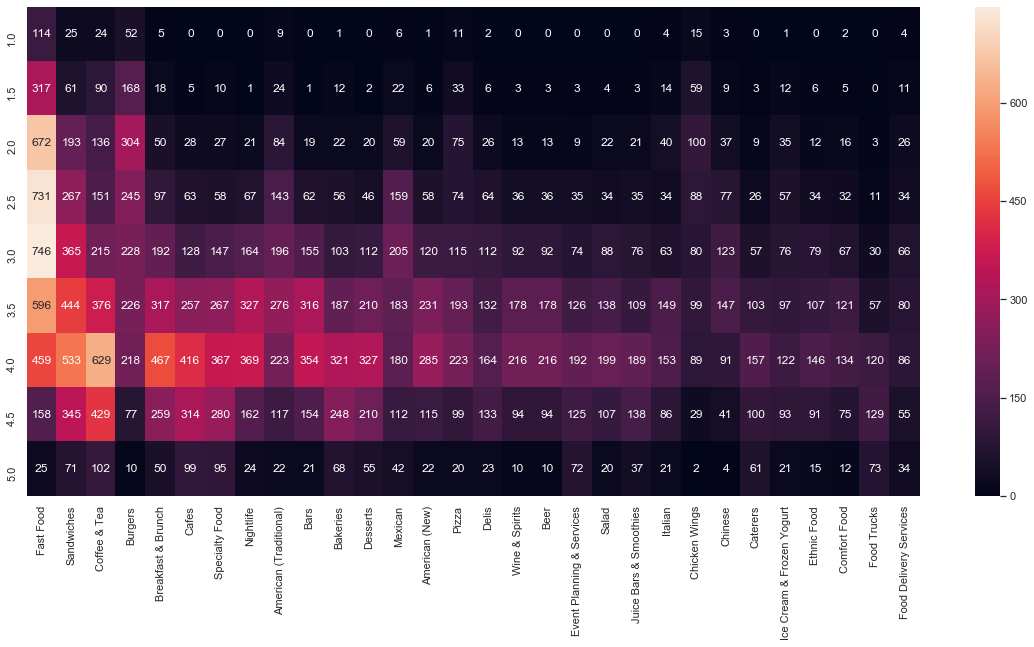

In [5]:
plot_data_heatmap(rest_data)

In [6]:
if_load = True

## Poisson Regression

### 1.1 Model
We picked one of the most common model for integer data, Poisson regression model

$$\beta_k \sim Normal(0,1)$$
$$\lambda_i = exp(\sum_{k}\beta_k*X_{ik})$$
$$P(Y|\lambda;X) = \frac{e^{-\lambda}\lambda^{Y}}{Y!} $$

In [6]:
pois = Pois()

### 1.2 Inference

We tried both SVI and MCMC

#### SVI

In [7]:
if not if_load:
    pois_svi_model, pois_svi_loss = \
        svi(data, train_ratings, pois.model, pois.guide, 5000,
        "pois", if_save=True, if_print=True)
else:
    pois_svi_loss = load("data_pickle/pois_svi_loss")

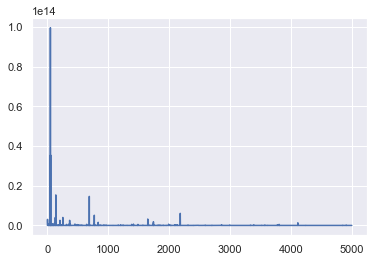

In [8]:
plot_loss(pois_svi_loss)

#### MCMC

In [9]:
if not if_load:
    pois_mcmc = mcmc(data, train_ratings, pois.model, "pois",
                     if_save=True, num_sample=200, num_w_steps=200)
else:
    pois_mcmc = load("data_pickle/pois_mcmc_model")

### 1.3 Criticism

#### SVI

In [10]:
if not if_load:
    sites = ['beta']
    pois_svi_betas = svi_posterior(pois_svi_model, data,
                                   train_ratings, pois.model,
                                   "pois", sites, if_save=True)
else:
    pois_svi_betas = load("data_pickle/pois_svi_beta_dict")

In [11]:
if is_cuda:
    marginal_svi_pois = \
                predictive_sampling(data, pois.model,
                                    {k: torch.from_numpy(v).cuda()
                                     for k, v in pois_svi_betas.items()})
else:
    marginal_svi_pois = \
                predictive_sampling(data, pois.model,
                                    {k: torch.from_numpy(v)
                                     for k, v in pois_svi_betas.items()})

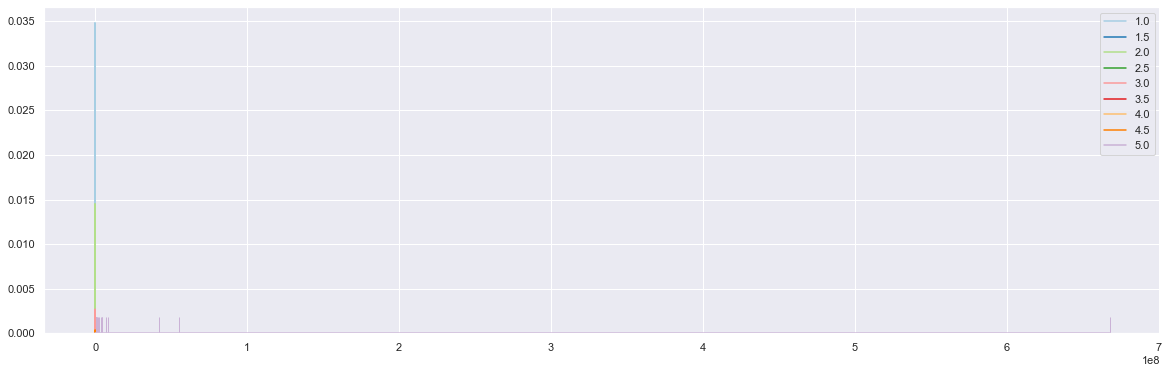

In [12]:
if is_cuda:
    train_ratings_np = train_ratings.detach().cpu().numpy()
    plot_rating_dist(marginal_svi_pois.detach().cpu().numpy(),
                     train_ratings_np)
else:
    plot_rating_dist(marginal_svi_pois, train_ratings)

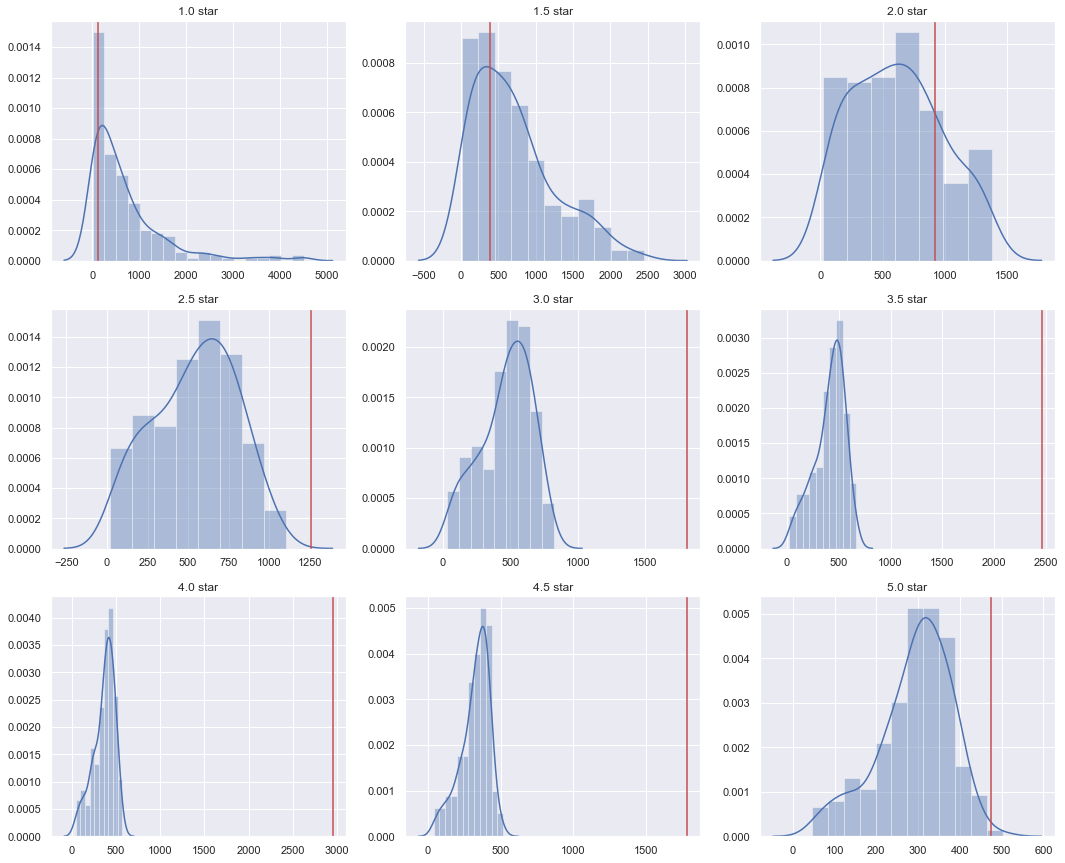

In [13]:
plot_count_dist(marginal_svi_pois, train_ratings, is_cuda=is_cuda)

#### MCMC

In [14]:
if not if_load:
    pois_mcmc_betas = mcmc_posterior(pois_mcmc, data, train_ratings,
                                     "pois", if_save=True,
                                     is_cuda=is_cuda)
else:
    pois_mcmc_betas = load("data_pickle/pois_mcmc_beta_dict")

In [15]:
if is_cuda:
    marginal_mcmc_pois = \
                predictive_sampling(data, pois.model,
                                    {k: torch.from_numpy(v).cuda()
                                     for k, v in pois_mcmc_betas.items()})
else:
    marginal_mcmc_pois = \
                predictive_sampling(data, pois.model,
                                    {k: torch.from_numpy(v)
                                     for k, v in pois_mcmc_betas.items()})

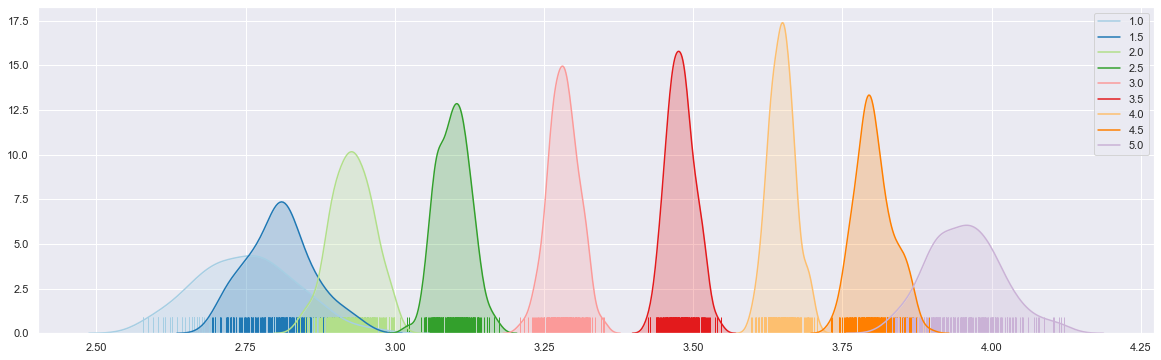

In [16]:
if is_cuda:
    train_ratings_np = train_ratings.detach().cpu().numpy()
    plot_rating_dist(marginal_mcmc_pois.detach().cpu().numpy(),
                     train_ratings_np)
else:
    plot_rating_dist(marginal_mcmc_pois, train_ratings)

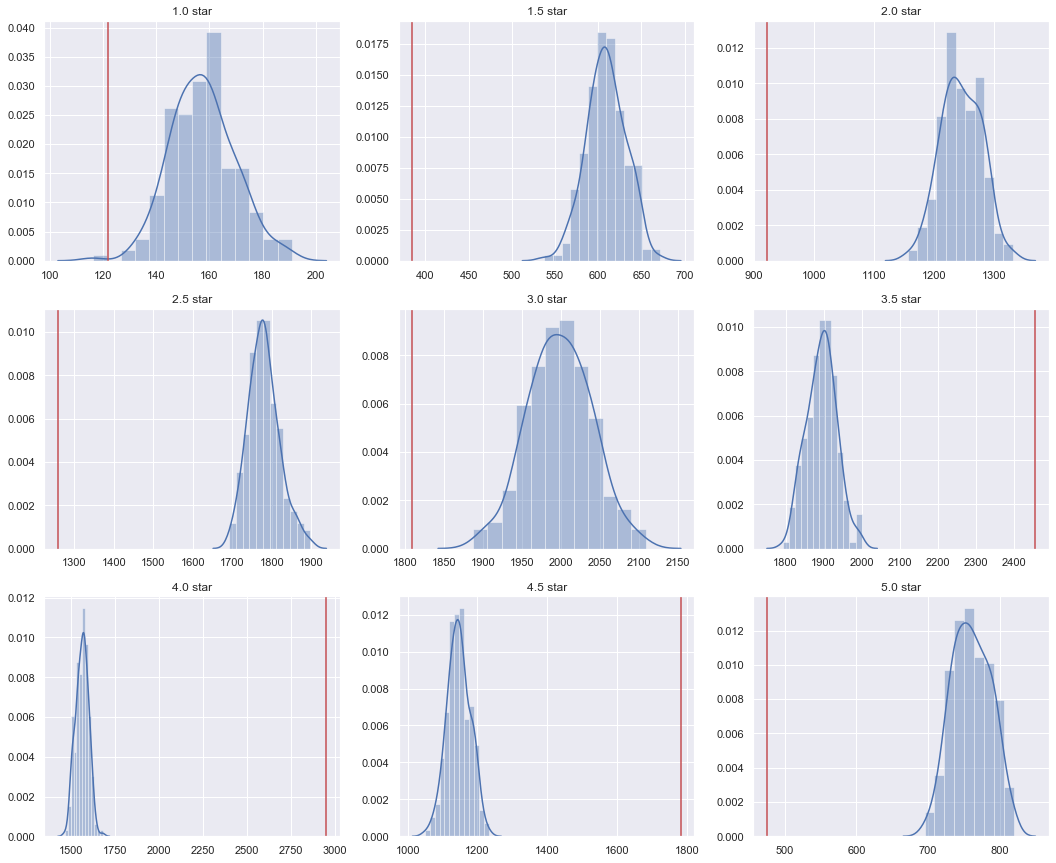

In [17]:
plot_count_dist(marginal_mcmc_pois, train_ratings, is_cuda=is_cuda)

As you can see above graph, this model has a big flaw where ratings could go beyond 8. We did some analysis, but since the model has a big flaw, we didn't include it. We tried Negative Binomial model which obviously doesn't work because it has greater variance. We also tried to infer with MLE, which had the same issue. So we skip the loops

As you can see above graph, this model has a big flaw where ratings could go beyond 10.

## Multinomial Logistic Regression Model

Since Poisson model without upper bound tends to give us unwanted predictions (More than 5 stars), we decided to use a model that has upper bounds. Among those, we chose multinomial logistic regression model.

### 2.1 Model

For all r ratings, k featrues
$$\beta_{rk} \sim Normal(0,1)$$
$$P(Y = r|\beta;X) = \frac{exp(\sum_{k}\beta_{rk} * X_{ik})}{\sum_{r}exp(\sum_{k}\beta_{rk} * X_{ik})}$$

In [21]:
mlrmodel = MlrModel()

### 2.2 Inference

#### SVI

In [22]:
if not if_load:
    mlr_svi_model, mlr_loss_list = \
        svi(data, train_ratings, mlrmodel.model, mlrmodel.guide, 5000,
        "mlr", if_save=True, if_print=True)
else:
    mlr_loss_list = load("data_pickle/mlr_svi_loss")

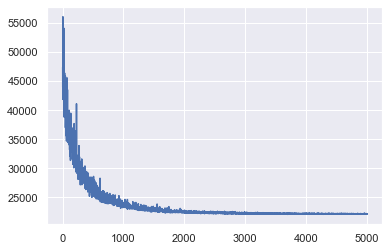

In [23]:
plot_loss(mlr_loss_list)

#### MCMC

In [24]:
if not if_load:
    mlr_mcmc = mcmc(data, train_ratings, mlrmodel.model, "mlr",
                    if_save=True, num_sample=200, num_w_steps=200)
else:
    mlr_mcmc = load("data_pickle/mlr_mcmc_model")

### 2.3 Criticism

#### SVI

In [25]:
if not if_load:
    sites = ["beta_1", "beta_1h", "beta_2",
             "beta_2h", "beta_3", "beta_3h",
             "beta_4", "beta_4h", "beta_5"]
    mlr_svi_betas = svi_posterior(mlr_svi_model, data, train_ratings,
                                  mlrmodel.model, "mlr", sites, if_save=True)
else:
    mlr_svi_betas = load("data_pickle/mlr_svi_beta_dict")

In [27]:
if is_cuda:
    marginal_svi_mlr = \
                predictive_sampling(data, mlrmodel.model,
                                    {k: torch.from_numpy(v).cuda()
                                     for k, v in mlr_svi_betas.items()})
else:
    marginal_svi_mlr = \
                predictive_sampling(data, mlrmodel.model,
                                    {k: torch.from_numpy(v)
                                     for k, v in mlr_svi_betas.items()})

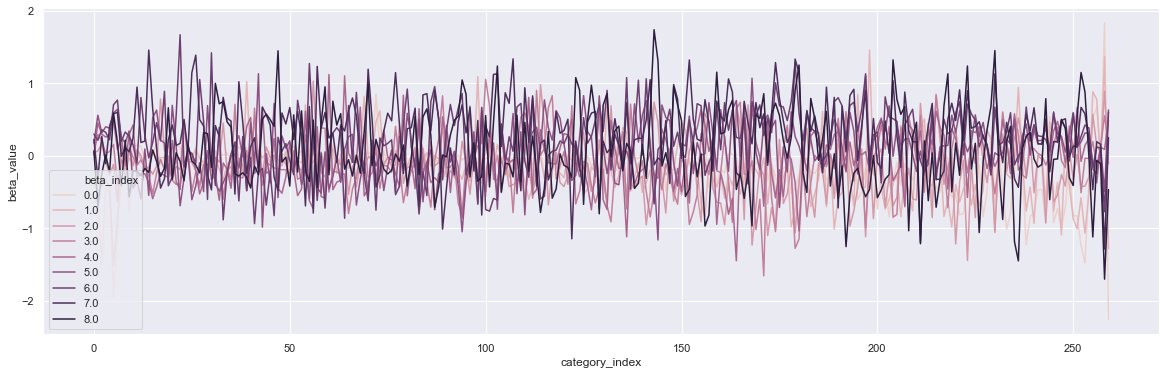

In [28]:
plot_beta_value(mlr_svi_betas)

Here we plot means of $\beta_{rk}$ for r $\in$ {1,2,3,4,5}, k $\in$ {1,2,...,241} so that we can compare with the one with MCMC

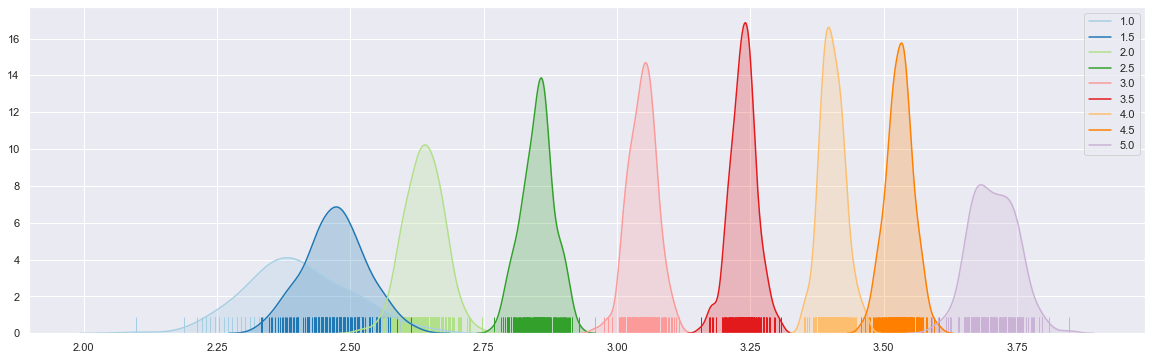

In [29]:
if is_cuda:
    train_ratings_np = train_ratings.detach().cpu().numpy()
    plot_rating_dist(marginal_svi_mlr.detach().cpu().numpy(),
                     train_ratings_np)
else:
    plot_rating_dist(marginal_svi_mlr, train_ratings)

Now we are comparing number of original ratings and ratings that are sampled from posterior predictive distribution

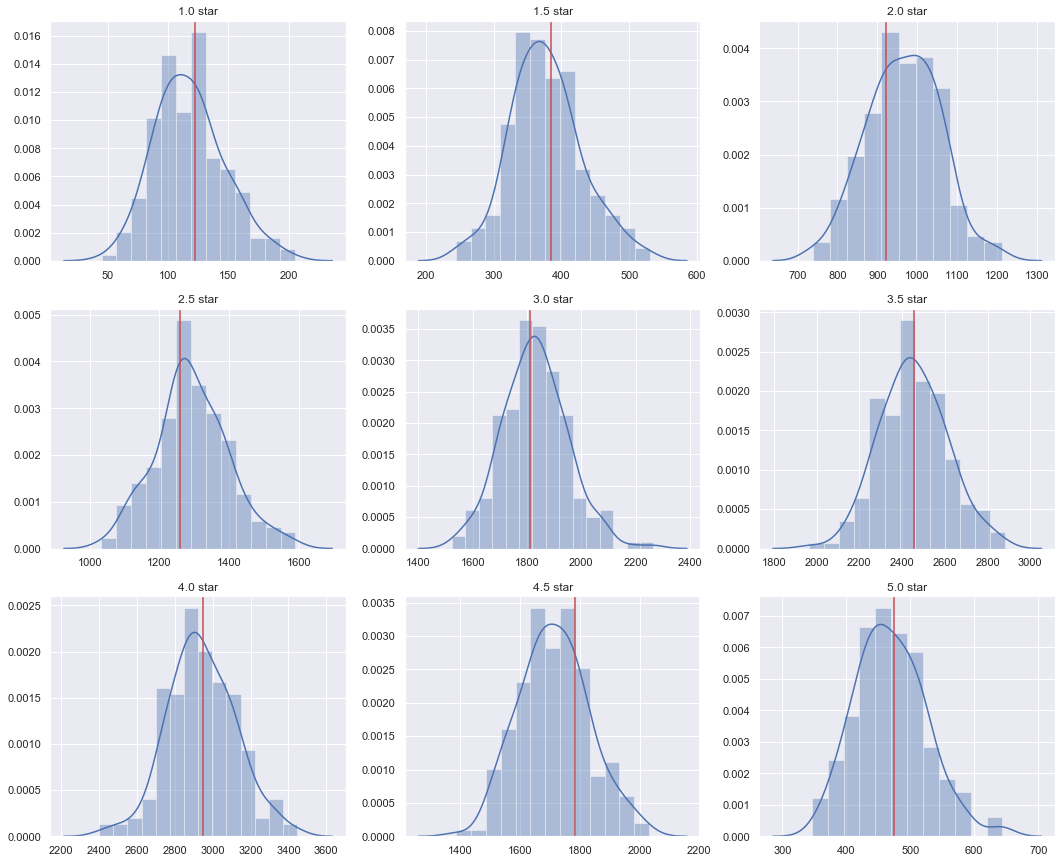

In [30]:
plot_count_dist(marginal_svi_mlr, train_ratings, is_cuda=is_cuda)

As you can see, sampled data and original data matches. It does significantly better than Poisson model.

Although general number of ratings matches, we are not sure the model works well. It could be the case that datapoints with ground truth higher rank became lower and that of low rank becomes higher to compensate the lack of numbers in higher rank. Thus we visualized the relation between original ratings and sampled ratings of the same data points features.

As you can see, in general, when data points with low ratings are given, lower ratings are sampled and the same applies to that of high ratings.

#### MCMC

In [31]:
if not if_load:
    mlr_mcmc_betas = mcmc_posterior(mlr_mcmc, data, train_ratings, "mlr",
                                    if_save=True, is_cuda=is_cuda)
else:
    mlr_mcmc_betas = load("data_pickle/mlr_mcmc_beta_dict")

In [32]:
if is_cuda:
    marginal_mcmc_mlr = \
                predictive_sampling(data, mlrmodel.model,
                                    {k: torch.from_numpy(v).cuda()
                                     for k, v in mlr_mcmc_betas.items()})
else:
    marginal_mcmc_mlr = predictive_sampling(data, mlrmodel.model,
                                            {k: torch.from_numpy(v)
                                             for k, v in mlr_mcmc_betas.items()})


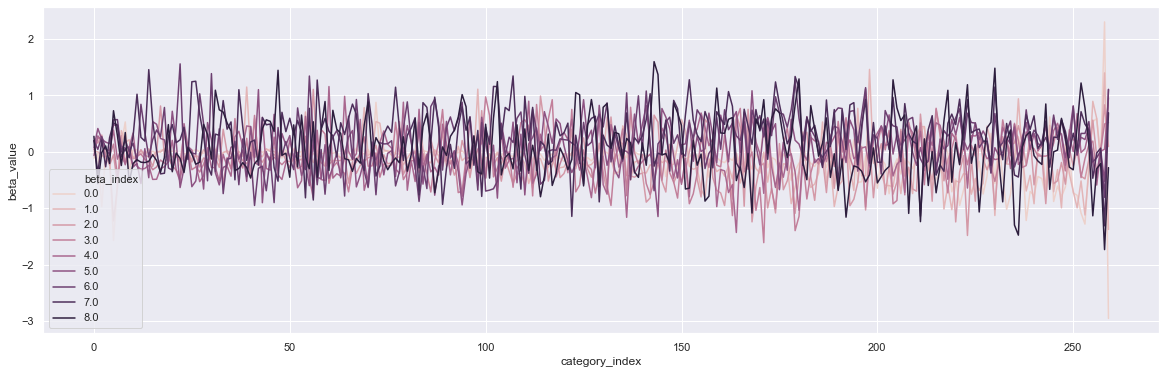

In [33]:
plot_beta_value(mlr_mcmc_betas)

Mean of sampled $\beta$ tends to be more spread than that of SVI

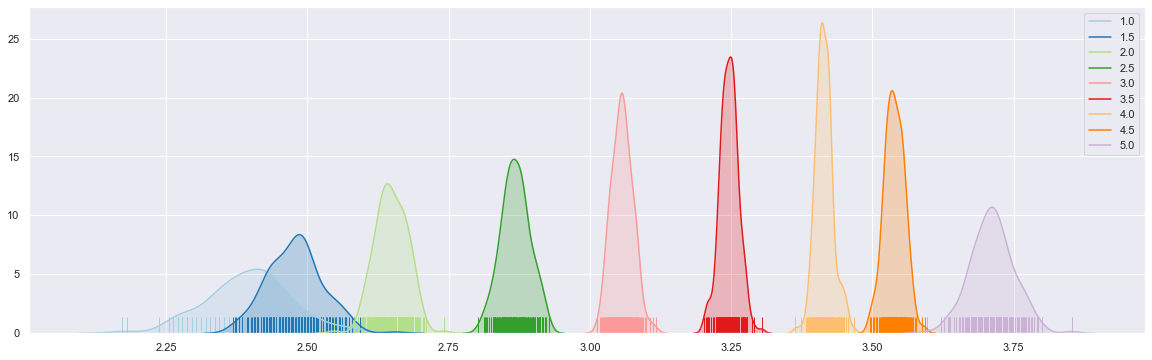

In [34]:
if is_cuda:
    train_ratings_np = train_ratings.detach().cpu().numpy()
    plot_rating_dist(marginal_mcmc_mlr.detach().cpu().numpy(), train_ratings_np)
else:
    plot_rating_dist(marginal_mcmc_mlr, train_ratings)

Both of SVI and MCMC are good, but the samples are better distributed over the ground truth

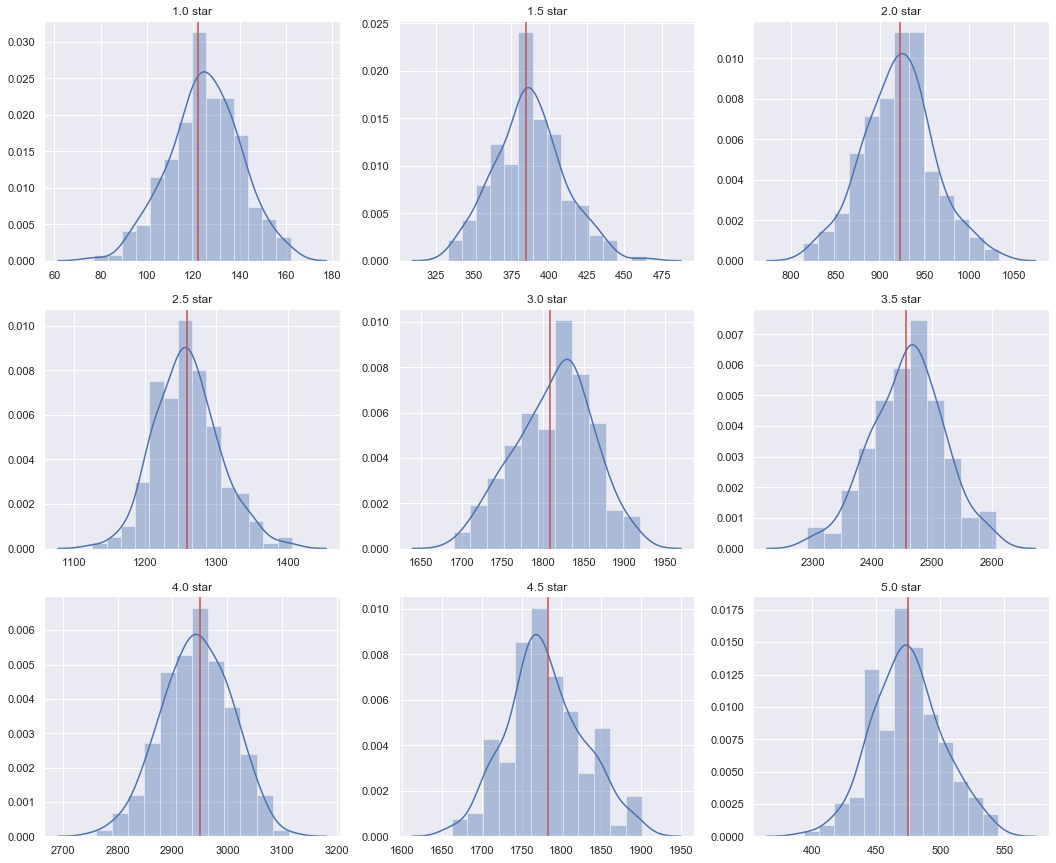

In [35]:
plot_count_dist(marginal_mcmc_mlr, train_ratings, is_cuda=is_cuda)

#### SVI vs MCMC

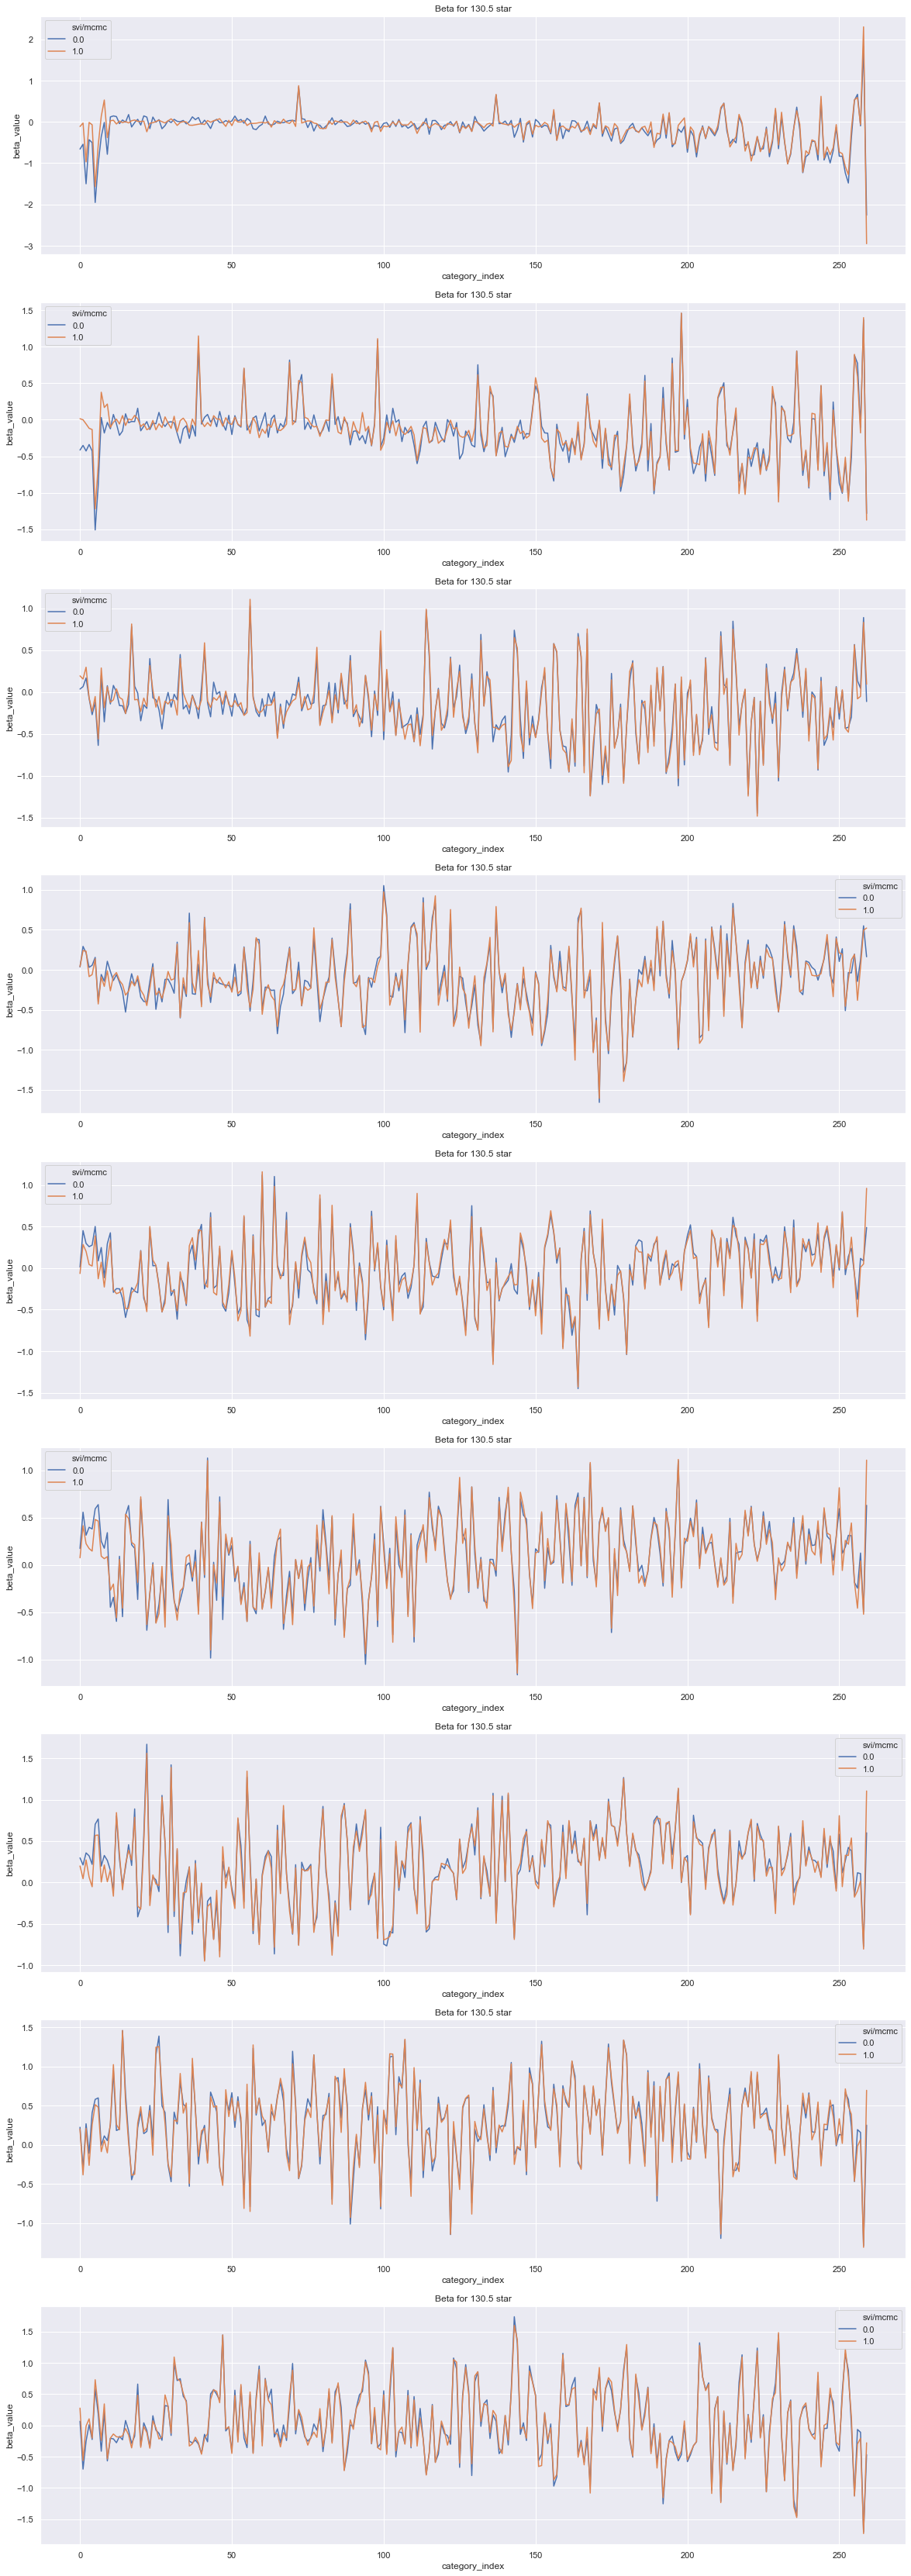

In [36]:
plot_compared_beta_value(mlr_svi_betas, mlr_mcmc_betas)

## Standard Bayesian approach

### 4.1 Model


So we wanted to do above prior setting approach more in a standard way. On top of that, we want to overcome the double dip problem of PPC. Since we have big dataset, we split it into three datasets $X1, X2, X3$

We can say they are all from the same distribution. We will use X1 to set prior, X2 to do inference, and X3 to do cross validation PPC

In [ ]:
#shuffle dataset

#Analyse X1

We see that there are mostly 3, 4 ratings and less 1, 5 ratings. Thus we tried to exponent of r = 3,4 high and 1,2,5 low.

$$\beta_{r} \sim Norm(\alpha_k, 1)$$
$\alpha_k$ is chosen randomly from [-2,2] + k for k = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
<br>
$\alpha_5 = \alpha_2$

### 4.2 Inference

### 4.3 Criticism

# Deconfounder

So it could be that there is confounder which affects all of our features and also affects the ratings of businesses. So we introduce deconfounder to improve our model.

## Factor Model

$$\beta_j \sim p(\beta_j)$$
$$z_i \sim p(z_i)$$
$$a_{ij} \sim p(a_{ij}| z_i, \beta_j)$$

We tried to use Poisson factor model, but since $a_{ij}$ was indicator variable, it didn't work well. So we decided to use logistic factorization model.

$$\beta_j \sim Normal(0,1)$$
$$z_i \sim Normal(0,1)$$
$$a_{ij} \sim Bernoulli(logit(z_i^T\beta_j))$$

In [37]:
lf_data = data[:, :-1]
lf = FactorModel(lf_data.shape)

Inference: SVI

In [51]:
if not if_load:
    lf_loss_list = lf.lf_inference(lf_data, lf.lf_model, lf.lf_guide, 3000)



Critisim: SVI

In [52]:
if not if_load:
    lf_post_sample = lf.replicate_data(lf.lf_model, lf.lf_guide, if_save=True)
    post_a = lf_post_sample['a']
    lf.plot_lf_ppc(lf_data, post_a, is_cuda=is_cuda)

<img src="factor_check.png">

Redo SVI on original dataset by appending z-hat

In [54]:
if not if_load:
    Z_hat = lf_post_sample['z'].mean(axis=0)
    X_aug = torch.cat([data[:, :-1], Z_hat], axis=1).detach()

In [55]:
aug_model = MlrModel()

In [57]:
if not if_load:
    aug_svi_model, aug_loss_list = \
    svi(X_aug, train_ratings, aug_model.model, aug_model.guide, 5000,
        "aug", if_save=True, if_print=True)

In [58]:
if not if_load:
    sites = ["beta_1", "beta_1h", "beta_2",
             "beta_2h", "beta_3", "beta_3h",
             "beta_4", "beta_4h", "beta_5"]
    aug_svi_betas = svi_posterior(aug_svi_model, X_aug, train_ratings,
                                  aug_model.model, "aug", sites, if_save=True)

In [59]:
if (not if_load) and is_cuda:
    marginal_svi_aug = \
                predictive_sampling(X_aug, aug_model.model,
                                    {k: torch.from_numpy(v).cuda()
                                     for k, v in aug_svi_betas.items()})

In [61]:
if not if_load:
    plot_beta_value(aug_svi_betas)

<img src="aug_beta.png">

In [62]:
if (not if_load) and is_cuda:
    train_ratings_np = train_ratings.detach().cpu().numpy()
    plot_rating_dist(marginal_svi_aug.detach().cpu().numpy(),
                     train_ratings_np)

<img src="aug_rating_dist.png">

In [64]:
if not if_load:
    plot_count_dist(marginal_svi_aug, train_ratings, is_cuda=is_cuda)

<img src="aug_count.png">